In [1]:
import sys
sys.path.append('../')

from mrl.imports import *
from mrl.core import *
from mrl.chem import *
from mrl.templates import *
from mrl.torch_imports import *
from mrl.torch_core import *
from mrl.layers import *
from mrl.dataloaders import *
from mrl.g_models import *
from mrl.agent import *
from mrl.policy_gradient import PolicyGradient, TRPO, PPO
from mrl.environment import *

/home/dmai/miniconda3/envs/mrl/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: to-Python converter for boost::shared_ptr<RDKit::FilterCatalogEntry const> already registered; second conversion method ignored.
  return f(*args, **kwds)


In [2]:
from mrl.reward import *

In [3]:
os.environ['ncpus'] = '0'

In [5]:
# vocab = CharacterVocab(SMILES_CHAR_VOCAB)

vocab = FuncVocab(SELFIES_VOCAB, split_selfie,
                  prefunc=smile_to_selfie, postfunc=selfie_to_smile)

# ds = TextDataset(['CCC'], vocab)

# d_vocab = len(vocab.itos)
# d_embedding = 256
# d_hidden = 1024
# n_layers = 3
# lstm_drop = 0.
# lin_drop = 0.
# bos_idx = vocab.stoi['bos']
# bidir = False
# tie_weights = True

# lm_model = LSTM_LM(d_vocab, d_embedding, d_hidden, n_layers,
#                 lstm_drop, lin_drop, bos_idx, bidir, tie_weights)

# lm_model.load_state_dict(torch.load('models/lstm_lm_small.pt'))

# loss = CrossEntropy()

def vector_reconstruction_collate2(batch, pad_idx, batch_first=True):

    x,y = vector_reconstruction_collate(batch, pad_idx, batch_first)
    x = x[::-1]
    output = (x,y)
    return to_device(output)

collate = partial(vector_reconstruction_collate2, pad_idx=vocab.stoi['pad'])
# ds = Vec_Recon_Dataset(['CCC'], vocab, ECFP6, collate_function=collate)
ds = Vec_Recon_Dataset(['CCC'], vocab, partial(failsafe_fp, fp_function=ECFP6), collate_function=collate)

d_vocab = len(vocab.itos)
d_embedding = 256
encoder_d_in = 2048
encoder_dims = [1024, 512]
encoder_drops = [0.1, 0.1]
d_hidden = 1024
n_layers = 3
d_latent = 512
dec_drop=0.0
condition_hidden=True
condition_output=True
prior=None
bos_idx=0

lm_model = MLP_VAE(d_vocab, d_embedding, encoder_d_in, encoder_dims, encoder_drops,
                d_hidden, n_layers, d_latent, dec_drop, condition_hidden, condition_output,
                prior, bos_idx)

lm_model.load_state_dict(torch.load('../nbs/untracked_files/fp_vae_chembl_selfies.pt'))

class VAELoss():
    def __init__(self, weight=1.):
        self.ce = CrossEntropy()
        self.weight = weight
        
    def __call__(self, inputs, targs):
        output, kl_loss = inputs
        return self.ce(output, targs) + self.weight*kl_loss

loss = VAELoss(weight=0.5)

# ds = Vec_Recon_Dataset(['CCC'], vocab, ECFP6)

# encoder = MLP_Encoder(2048, [1024, 512], 512, [0.1, 0.1])
# d_vocab = len(vocab.itos)
# d_embedding = 256
# d_hidden = 1024
# d_latent = 512
# n_layers = 3
# lstm_drop = 0.0
# lin_drop = 0.0
# bidir = False
# condition_hidden = True
# condition_output = False
# bos_idx = vocab.stoi['bos']

# lm_model = Conditional_LSTM_LM(encoder, d_vocab, d_embedding, d_hidden, d_latent, n_layers,
#                 lstm_drop, lin_drop, bidir, condition_hidden, condition_output, bos_idx)

# lm_model.load_state_dict(torch.load('../nbs/untracked_files/fp_cond_lstm_lm_zinc.pt'))

# loss = CrossEntropy()

In [7]:
lm_model.z_scale = 0.

In [8]:
# lm_model.set_prior_from_stats(torch.zeros((512,)), torch.zeros((512,)), trainable=True)

In [9]:
vh = ValueHead(256)
# vh = None

In [10]:
# latents = torch.randn((512, lm_model.encoder.d_latent))
latents = None

In [11]:
# lm_model.prior = SphericalPrior(torch.zeros((lm_model.encoder.d_latent)), 
#                                 torch.zeros((lm_model.encoder.d_latent)), 
#                                 trainable=True)

lm_model.prior = NormalPrior(torch.zeros((lm_model.encoder.d_latent)), 
                                torch.zeros((lm_model.encoder.d_latent)), 
                                trainable=True)

In [12]:
agent = GenerativeAgent(lm_model, vocab, loss, ds, value_head=vh, opt_kwargs={'lr':1e-3},
                       base_update=0.9, v_update=0.9, vopt_kwargs={'lr':1e-3},
                       latents=latents, lopt_kwargs={'lr':5e-3})

In [13]:
freeze(agent.model.encoder)
freeze(agent.model.transition)
freeze(agent.model.decoder)

In [14]:
def scale_sa(sa):
    return (10-sa)/9

In [15]:
# template = Template([ValidityFilter(), SingleCompoundFilter()],
#                     [QEDFilter(None, None, score=PassThroughScore()),
#                      SAFilter(None, None, 
#                               score=PropertyFunctionScore(scale_sa))], fail_score=-1.)

template = Template([ValidityFilter(), SingleCompoundFilter()],
                    [QEDFilter(0.5, None, score=1.),
                     SAFilter(None, 4, score=1.)], 
                    fail_score=-10.)

In [16]:
update_cb = UpdateBaselineCB(agent, 10, 'base_update')
# stat_cb = StatsCallback('latent', 'stat_cb', 10)
# roll_cb = RetrainRollback(agent, 98, 0.5, 5e-5, 64, 'latent_valid', 20, 0.5, 'rb')

stat_cb = StatsCallback('live', 'stat_cb', 10)
roll_cb = RetrainRollback(agent, 98, 0.5, 5e-5, 64, 'live_valid', 20, 0.5, 'rb')

reward_cb = LogSampler('rewards', 10, 95, buffer_size=10)
enum_cb = LogEnumerator('rewards', 10, buffer_size=5, percentile=98)
novel_cb = NoveltyBonus(0.1, 'novel')

In [17]:
cbs = [update_cb, stat_cb, reward_cb, enum_cb, novel_cb]

In [18]:
df = pd.read_csv('../nbs/untracked_files/affinity_data.csv')

r_model = MLP_Encoder(2048, [1024, 512, 256, 128], 1, [0.2, 0.2, 0.2, 0.2])

r_ds = Vec_Prediction_Dataset(df.smiles.values, df.value.values/10, ECFP6)

r_agent = PredictiveAgent(r_model, MSELoss(), r_ds, opt_kwargs={'lr':1e-3})

r_agent.load_weights('../nbs/untracked_files/aff_pred.pt')

r_model.eval();

freeze(r_model)


aff_reward = SampleReward(r_agent.predict_data, True, 'aff', weight=-10.)

In [19]:
gen_bs = 1000
bs = 200

In [20]:
agent_cb = GenAgentCallback(agent, 'generative')

In [21]:
# sampler1 = ModelSampler(agent, agent.model, 'latent', 500, 1., gen_bs, latent=True, temperature=1.)
sampler2 = ModelSampler(agent, agent.model, 'live', 500, 0.6, gen_bs, latent=False, track=True)
sampler3 = ModelSampler(agent, agent.base_model, 'base', 500, 0., gen_bs)

# samplers = [sampler1, sampler2, sampler3]
# samplers = [sampler1, sampler3]
samplers = [sampler2, sampler3]

In [19]:
# pg = PolicyGradient(ratio=True)
# pg = TRPO(0.97, 4.)
pg = PPO(0.99,
        0.5,
        lam=0.95,
        v_coef=0.5,
        cliprange=0.3,
        v_cliprange=0.3,
        ent_coef=0.01,
        kl_target=0.03,
        kl_horizon=3000,
        scale_rewards=True)
loss1 = LossCallback(pg, 'pg')

In [22]:
prior_loss = LossCallback(PriorLoss(agent), 'prior')
hist_prior_loss = HistoricPriorLoss(agent, 95, 100, 5)

In [23]:
template_cb = TemplateCallback(template)

In [24]:
env = Environment(agent_cb, template_cb, samplers=samplers, reward_cbs=[aff_reward], 
                  loss_cbs=[prior_loss, hist_prior_loss], cbs=cbs)

# env = Environment(agent_cb, template_cb, samplers=samplers, reward_cbs=[aff_reward], 
#                   loss_cbs=[loss1], cbs=cbs)

In [25]:
%%time
env.fit(bs, 90, 10, 2)

iterations,rewards,valid,diversity,template,aff,pg,novel,latent_diversity,latent_valid,latent_rewards,latent_new,latent_p90,latent_max
0,-6.821,0.955,1.000,0.969,-7.889,0.633,0.100,1.000,0.957,-6.788,1.000,-4.406,-2.096
2,-6.711,0.960,1.000,1.073,-7.884,0.829,0.100,1.000,0.950,-6.842,1.000,-4.552,-2.659
4,-6.760,0.930,1.000,1.070,-7.930,0.774,0.100,1.000,0.907,-6.816,1.000,-4.531,-3.088
6,-6.936,0.900,1.000,1.039,-8.075,0.634,0.100,1.000,0.879,-7.087,1.000,-4.851,-1.436
8,-6.848,0.920,1.000,0.984,-7.932,0.605,0.100,1.000,0.921,-6.921,1.000,-4.738,-1.580


CPU times: user 13.8 s, sys: 49.8 ms, total: 13.9 s
Wall time: 13.9 s


In [25]:
%%time
env.fit(bs, 90, 1000, 5)

iterations,rewards,template,diversity,valid,bs,prior,live_diversity,live_valid,live_rewards,live_new,aff,prior_his,live_p90,live_max,novel
0,-6.727,1.455,1.000,0.990,198,0.000,1.000,0.983,-6.802,1.000,-8.281,0.000,-4.481,-0.536,0.100
5,-6.686,1.482,1.000,0.995,199,-0.000,1.000,0.992,-6.732,1.000,-8.268,0.000,-4.219,-1.679,0.100
10,-6.764,1.328,1.000,0.990,198,-0.000,1.000,0.983,-6.649,1.000,-8.192,-0.000,-3.840,0.070,0.100
15,-6.789,1.409,1.000,0.990,198,-0.000,1.000,0.983,-6.856,1.000,-8.298,-0.000,-4.734,-2.977,0.100
20,-6.701,1.401,1.000,0.985,197,-0.000,1.000,0.975,-6.554,1.000,-8.202,-0.000,-4.080,-1.432,0.100
25,-6.234,1.313,1.000,0.975,195,-0.000,1.000,0.958,-6.996,1.000,-7.647,-0.000,-4.457,-2.971,0.099
30,-5.963,1.360,1.000,1.000,200,-0.000,1.000,1.000,-6.568,1.000,-7.423,-0.000,-3.895,0.069,0.100
35,-6.384,1.407,1.000,0.995,199,-0.000,1.000,0.992,-7.023,1.000,-7.891,-0.000,-4.860,-1.579,0.100
40,-6.165,1.379,1.000,0.990,198,-0.000,1.000,0.983,-6.393,1.000,-7.643,-0.000,-3.718,-1.218,0.099
45,-6.359,1.401,1.000,0.985,197,-0.000,1.000,0.975,-6.922,1.000,-7.859,-0.000,-4.747,-1.546,0.099


CPU times: user 40min 11s, sys: 3.14 s, total: 40min 14s
Wall time: 40min 14s


In [27]:
%%time
env.fit(bs, 90, 1000, 5)

iterations,rewards,template,diversity,valid,bs,prior,live_diversity,live_valid,live_rewards,live_new,aff,prior_his,live_p90,live_max,novel
1000,-5.626,1.216,1.000,0.995,199,0.122,1.000,0.992,-6.652,1.000,-6.940,-2.661,-4.132,-0.855,0.097
1005,-5.930,1.222,1.000,0.990,198,0.809,1.000,0.983,-6.964,1.000,-7.252,-2.524,-4.744,-2.519,0.099
1010,-5.937,1.313,1.000,0.990,198,1.342,1.000,0.983,-6.944,1.000,-7.349,-3.471,-4.301,-0.647,0.099
1015,-5.871,1.251,1.000,0.995,199,1.052,1.000,0.992,-6.803,0.983,-7.220,-2.999,-4.633,-2.107,0.098
1020,-5.527,1.167,1.000,0.990,198,0.746,1.000,0.983,-6.797,1.000,-6.790,-3.190,-4.387,-2.668,0.096
1025,-5.997,1.286,1.000,0.980,196,0.285,1.000,0.967,-6.685,0.983,-7.380,-1.238,-4.685,-1.660,0.098
1030,-6.063,1.300,1.000,1.000,200,2.006,1.000,1.000,-7.044,0.992,-7.462,-2.191,-4.713,-0.815,0.098
1035,-5.434,1.171,1.000,0.995,199,-0.155,1.000,0.992,-6.630,0.983,-6.704,-0.996,-4.003,-1.075,0.099
1040,-5.910,1.201,1.000,0.995,199,0.703,1.000,0.992,-6.826,0.983,-7.209,-2.043,-4.538,-2.107,0.097
1045,-5.693,1.140,1.000,1.000,200,0.611,1.000,1.000,-6.627,0.983,-6.932,-0.594,-3.957,-2.171,0.098


KeyboardInterrupt: 

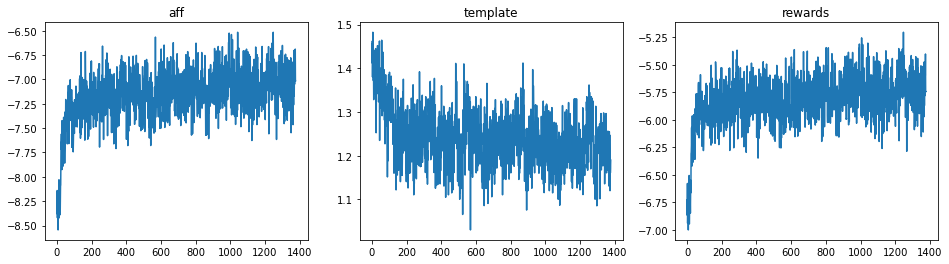

In [28]:
fig, axes = plt.subplots(1, 3, figsize=(16,4))
plot_vals = ['aff', 'template', 'rewards']

for i, ax in enumerate(axes.flat):
    ax.plot(np.stack(env.log.metrics[plot_vals[i]]))
    ax.set_title(plot_vals[i])